## A quick look at the data

The data looks very straightforward for this project. The goal is to predict winPlacePerc, a percentile score where 1 = winning player/team and 0 = the last-place player/team.

I made a correlation heatmap. killPlace is highly correlated with winPlacePerc, and many other features.

I ran a few simple regression models on the raw data. GradientBoostingRegressor performs better (R2 = 0.87) than Ridge[Linear Regressor] (R2 = 0.79) but runs significantly more slowly (GBR: 7 mins, Ridge: 1 min). Consider running Ridge or even LinearRegression for quick evaluation of engineered features.

### TODO: Feature Engineering (in a new file)

## Data fields

    DBNOs (Down-But-Not-Outs) - Number of enemy players knocked down.
    assists - Number of enemy players this player damaged that were killed by teammates.
    boosts - Number of boost items used.
    damageDealt - Total damage dealt. Note: Self inflicted damage is subtracted.
    headshotKills - Number of enemy players killed with headshots.
    heals - Number of healing items used.
    killPlace - Ranking in match of number of enemy players killed.
    killPoints - Kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.)
    killStreaks - Max number of enemy players killed in a short amount of time.
    kills - Number of enemy players killed.
    longestKill - Longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.
    matchId - Integer ID to identify match. There are no matches that are in both the training and testing set.
    revives - Number of times this player revived teammates.
    rideDistance - Total distance traveled in vehicles measured in meters.
    roadKills - Number of kills while in a vehicle.
    swimDistance - Total distance traveled by swimming measured in meters.
    teamKills - Number of times this player killed a teammate.
    vehicleDestroys - Number of vehicles destroyed.
    walkDistance - Total distance traveled on foot measured in meters.
    weaponsAcquired - Number of weapons picked up.
    winPoints - Win-based external ranking of player. (Think of this as an Elo ranking where only winning matters.)
    groupId - Integer ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.
    numGroups - Number of groups we have data for in the match.
    maxPlace - Worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.
    winPlacePerc - The target of prediction. This is a percentile winning placement, where 1 corresponds to 1st place, and 0 corresponds to last place in the match. It is calculated off of maxPlace, not numGroups, so it is possible to have missing chunks in a match.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
import timeit
import datetime
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor

pd.options.display.max_columns = None

In [5]:
#df = pd.read_csv('data/train.csv', nrows=1870000)
df = pd.read_csv('data/train.csv')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4357336 entries, 0 to 4357335
Data columns (total 26 columns):
Id                 int64
groupId            int64
matchId            int64
assists            int64
boosts             int64
damageDealt        float64
DBNOs              int64
headshotKills      int64
heals              int64
killPlace          int64
killPoints         int64
kills              int64
killStreaks        int64
longestKill        float64
maxPlace           int64
numGroups          int64
revives            int64
rideDistance       float64
roadKills          int64
swimDistance       float64
teamKills          int64
vehicleDestroys    int64
walkDistance       float64
weaponsAcquired    int64
winPoints          int64
winPlacePerc       float64
dtypes: float64(6), int64(20)
memory usage: 864.3 MB


In [11]:
df.head(15)

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,0,24,0,0,5,247.30,2,0,4,17,1050,2,1,65.320,29,28,1,591.3,0,0.0000,0,0,782.40,4,1458,0.8571
1,1,440875,1,1,0,37.65,1,1,0,45,1072,1,1,13.550,26,23,0,0.0,0,0.0000,0,0,119.60,3,1511,0.0400
2,2,878242,2,0,1,93.73,1,0,2,54,1404,0,0,0.000,28,28,1,0.0,0,0.0000,0,0,3248.00,5,1583,0.7407
3,3,1319841,3,0,0,95.88,0,0,0,86,1069,0,0,0.000,97,94,0,0.0,0,0.0000,0,0,21.49,1,1489,0.1146
4,4,1757883,4,0,1,0.00,0,0,1,58,1034,0,0,0.000,47,41,0,0.0,0,0.0000,0,0,640.80,4,1475,0.5217
5,5,2200824,5,0,2,128.10,0,0,0,25,1000,1,1,27.300,96,96,0,2221.0,0,0.0000,0,0,1016.00,4,1500,0.9368
6,6,2568717,6,1,0,130.30,0,0,0,28,1037,1,1,5.954,44,40,0,721.7,0,0.0000,0,0,280.10,3,1495,0.3721
7,7,2612473,7,1,1,661.80,2,3,2,3,1148,5,2,36.640,46,46,0,0.0,0,0.0000,0,0,2617.00,4,1479,1.0000
8,8,2656377,8,0,3,94.72,0,0,5,50,1286,0,0,0.000,28,28,0,2963.0,0,28.9000,0,0,3139.00,5,1528,0.7037
9,9,2700597,9,0,0,137.60,0,0,0,81,1000,0,0,0.000,25,23,0,0.0,0,0.0000,0,0,238.70,3,1500,0.0417


In [7]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'maxPlace', 'numGroups', 'revives',
       'rideDistance', 'roadKills', 'swimDistance', 'teamKills',
       'vehicleDestroys', 'walkDistance', 'weaponsAcquired', 'winPoints',
       'winPlacePerc'],
      dtype='object')

In [14]:
# aggregation test. groupId is a player team ID, and winPlacePerc is based on the team's best-performing member.
df.groupby(['groupId'])['heals'].mean()

# should explore features for maximum values among players in your team
# (Ex; team's max walk distance, team's max killplace)

groupId
1           1.666667
2           0.000000
7           3.000000
9           0.000000
10          0.000000
12          0.666667
14          0.000000
16          0.333333
17          0.000000
18          0.000000
21          0.000000
24          6.500000
26          1.000000
29          2.666667
30          1.000000
32          3.000000
34          0.142857
36          0.333333
38          1.166667
42          0.666667
46          0.000000
47          0.000000
49          0.000000
51          0.250000
54          1.750000
57          4.000000
59         10.500000
62          0.500000
64          0.666667
67          0.000000
             ...    
2700558     5.000000
2700559     1.000000
2700560     2.333333
2700561     0.000000
2700562     2.250000
2700563     6.000000
2700566     0.000000
2700567     0.000000
2700569     2.000000
2700571     0.000000
2700572     0.000000
2700573     0.666667
2700574     0.000000
2700575     0.000000
2700576     0.000000
2700577     1.000000
27005

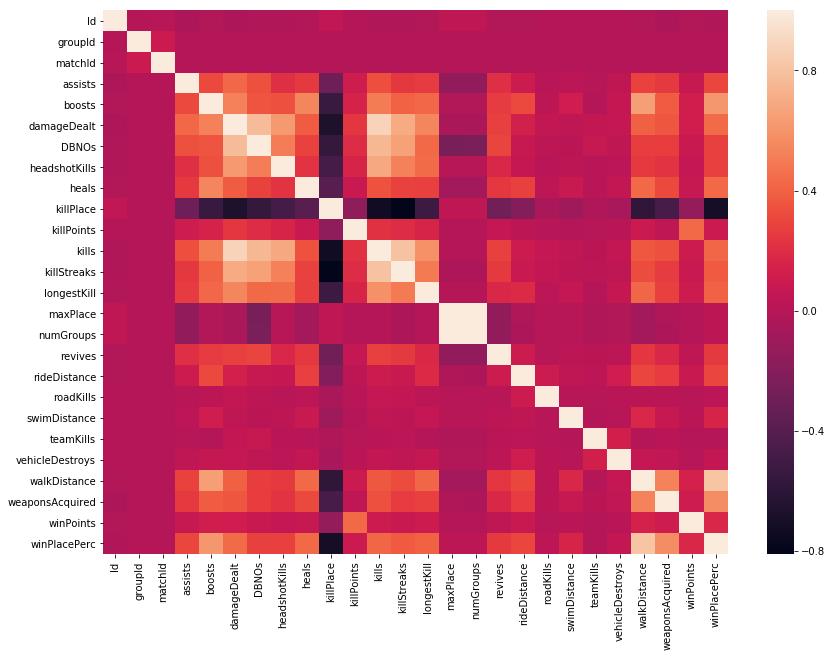

In [16]:
fig, ax = plt.subplots(figsize=(14,10)) 
sns.heatmap(df.corr())

In [36]:
rdg = Ridge()
X = df.drop('winPlacePerc', axis=1)
y = df['winPlacePerc']

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [19]:
print(datetime.datetime.now())
rdg.fit(X_train, y_train)
print(datetime.datetime.now())

2018-10-10 15:32:46.212796
2018-10-10 15:33:43.240582


In [20]:
y_pred = rdg.predict(X_test)

In [21]:
rdg.score(X_test, y_test)

0.7922234021624289

In [23]:
gbr = GradientBoostingRegressor()

In [24]:
print(datetime.datetime.now())
gbr.fit(X_train, y_train)
print(datetime.datetime.now())

2018-10-10 15:33:51.935794
2018-10-10 15:41:03.032543


In [25]:
gbr.score(X_test, y_test)

0.872694449938445

In [26]:
fi = gbr.feature_importances_

In [27]:
names = X_test.columns

In [28]:
sorted(list(zip(names, fi)), key=lambda x: x[1])

[('Id', 0.0),
 ('groupId', 0.0),
 ('matchId', 0.0),
 ('headshotKills', 0.0),
 ('roadKills', 0.0),
 ('vehicleDestroys', 0.0),
 ('damageDealt', 0.00019364160082873262),
 ('teamKills', 0.002653089375942816),
 ('killPoints', 0.003863755155717219),
 ('rideDistance', 0.004525396112893932),
 ('revives', 0.006004524059799602),
 ('longestKill', 0.006337313134963281),
 ('swimDistance', 0.007508602394452391),
 ('heals', 0.009730957866406684),
 ('weaponsAcquired', 0.012884327361752592),
 ('DBNOs', 0.015962874634683093),
 ('winPoints', 0.018904204508595833),
 ('boosts', 0.028954451458239872),
 ('assists', 0.03030774882632564),
 ('killStreaks', 0.05298458580752392),
 ('kills', 0.06766201593591352),
 ('maxPlace', 0.0926044107581247),
 ('numGroups', 0.1270976027483637),
 ('walkDistance', 0.24409062851253577),
 ('killPlace', 0.26772986974693674)]

In [28]:
from xgboost import XGBRegressor

In [29]:
xgb = XGBRegressor()

In [31]:
print(datetime.datetime.now())
xgb.fit(X_train, y_train)
print(datetime.datetime.now())

2018-10-10 15:41:04.691747
2018-10-10 15:44:07.265739


In [32]:
xgb.score(X_test, y_test)

0.8726929199457596

In [39]:
print(datetime.datetime.now())
xgb.fit(X_train, y_train)
print(datetime.datetime.now()) #all data

2018-10-12 17:35:47.248113
2018-10-12 17:46:10.543253


In [40]:
xgb.score(X_test, y_test) # all data

0.8861334378226031

In [42]:
xgb.score(X_train, y_train)

0.8866170834436402

In [44]:
from sklearn.metrics import r2_score
y_pred = xgb.predict(X_test)
r2_score(y_test, y_pred)

0.8861334378226031

In [31]:
X = df.drop(['Id','groupId','matchId','headshotKills','roadKills','vehicleDestroys','winPlacePerc'], axis=1)
y = df['winPlacePerc']

In [41]:
X.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,maxPlace,numGroups,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,0,24,0,0,5,247.30,2,0,4,17,1050,2,1,65.32,29,28,1,591.3,0,0.0,0,0,782.40,4,1458
1,1,440875,1,1,0,37.65,1,1,0,45,1072,1,1,13.55,26,23,0,0.0,0,0.0,0,0,119.60,3,1511
2,2,878242,2,0,1,93.73,1,0,2,54,1404,0,0,0.00,28,28,1,0.0,0,0.0,0,0,3248.00,5,1583
3,3,1319841,3,0,0,95.88,0,0,0,86,1069,0,0,0.00,97,94,0,0.0,0,0.0,0,0,21.49,1,1489
4,4,1757883,4,0,1,0.00,0,0,1,58,1034,0,0,0.00,47,41,0,0.0,0,0.0,0,0,640.80,4,1475


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [34]:
print(datetime.datetime.now())
xgb.fit(X_train, y_train)
print(datetime.datetime.now())

2018-10-12 17:22:03.279214
2018-10-12 17:29:46.911151


In [35]:
xgb.score(X_test, y_test)

0.8861334378226031

In [51]:
r = xgb.score(X_test, y_test)
n = len(y_test)
k = 19
1-((1-r*r)*(n-1)/(n-k-1))


0.7852287236155243